# Сравниваем качество работы модели, оптимизированной разными способами

Провести эксперименты по вычислению mse, mae с использованием разных размеров батчей, так как не сходятся ошибки из блокнота с обученияем (батчи) и в этом блокноте (единоразовое вычисление)

## Подключение библиотек

In [26]:
import pandas as pd
import os
import glob
from facenet_pytorch import MTCNN
import cv2
import torch
from torchinfo import summary
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import math
from torch.optim.lr_scheduler import ExponentialLR
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import confusion_matrix
from typing import Tuple
import argparse
import onnx
import onnxruntime
import sys
import tensorrt as trt
from PIL import Image
import pycuda.driver as cuda
import pycuda.autoinit
from typing import Tuple, Union
import logging
import time

## Используемые классы

In [27]:
class MobileFaceQualityNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.mobilenet_v3_small(pretrained=True)
        # Заменяем последние 2 полносвязных слоя на имеющие нужную размерность
        self.backbone.classifier[0] = nn.Linear(576, 256)
        self.backbone.classifier[3] = nn.Linear(256, 1)

        
    def get_layers_names(self):
         return dict(self.backbone.named_modules())

        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [28]:
class FaceQualityDataset(Dataset):
    '''Класс для создания датасетов'''
    
    def __init__(self, dataframe: pd.DataFrame, device: str, transform: object, transfer_path: bool = False):
        '''Входные параметры:
        dataframe: pd.DataFrame - датафрейм с адресами изображений и скорами
        device: str - имя устройства, на котором будут обрабатываться данные
        transform: object - список преобразований, которым будут подвергнуты изображения и маски
        transfer_path: bool - флаг, нужно ли передавать названия файлов через объект'''
        
        self.image_paths = dataframe['path']
        self.target = dataframe['score']
        self.transform = transform
        self.data_len = len(dataframe.index)
        self.device = device
        self.transfer_path = transfer_path
        
    def __getitem__(self, index: int):
        '''Входные параметры:
        index: int - индекс для обращения к элементам датафрейма dataframe
        Возвращаемые значения:
        Tuple[torch.Tensor] - кортеж из тензорного представления изображения лица'''
        
        image = cv2.imread(self.image_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('float')/255.0

        transformed = self.transform(image=image)
        transformed_image = transformed['image'].to(self.device).float()
        
        target = torch.from_numpy(np.array(self.target[index])).to(self.device).float()
        
        if self.transfer_path:
            return transformed_image, target, self.image_paths[index]
        else:
            return transformed_image, target

    def __len__(self):
        return self.data_len

In [99]:
class ModelWrapper(nn.Module):
    '''Класс, реализующий функционал для обучения нейросети классификации наличия маски на лице'''
    
    def __init__(self, model: object):
        '''Конструктор класса
        Входные параметры:
        model: object - последовательность слоев или модель, через которую будут проходить данные'''
        
        super(ModelWrapper, self).__init__()
        self.model = model

        
    def forward(self, input_data):
        '''Метод прямого прохода через объект класса
        Входные параметры:
        input_data: torch.Tensor - тензорное представление изображения лица
        Возвращаемые значения: 
        output_data: torch.Tensor - предсказанные координаты ключевых точек в тензорном формате'''
        
        output_data = self.model(input_data)
        return output_data
    
    
    def valid(self, criterion: object, metric: object, valid_data_loader: DataLoader):
        '''Метод для валидации модели
        Входные параметры:
        criterion: object - объект для вычисления loss
        metric: object - объект для вычисления метрики качества
        valid_data_loader: DataLoader - загрузчик данных для валидации
        Возвращаемые значения:
        result: dict - словарь со значениями loss и метрики при валидации'''
        
        self.model.eval()
        valid_metrics = []
        valid_losses = []
        result = {}
        
        with torch.no_grad():
            for batch_idx, data in enumerate(valid_data_loader): 
                inputs = data[0]
                target_scores = data[1]

                pred_scores = self.model(inputs)
                pred_scores = pred_scores.view(1, -1)[0]      # [16, 1] -> [16]
                loss = criterion(pred_scores, target_scores)
                metric_ = metric(pred_scores, target_scores)
                valid_losses.append(loss.item())
                valid_metrics.append(metric_.item())
             
        valid_loss = np.mean(valid_losses)
        valid_metric = np.mean(valid_metrics)
    
        result['valid_loss'] = valid_loss
        result['valid_metric'] = valid_metric

        self.model.train()
        
        return result

    
    def load(self, path_to_model: str = './face_model.pth'):
        '''Метод загрузки весов модели
        Входные параметры:
        path_to_model: str - директория с сохраненными весами модели'''
        
        self.model.load_state_dict(torch.load(path_to_model))

In [113]:
# From https://github.com/NVIDIA/object-detection-tensorrt-example/blob/master/SSD_Model/utils/inference.py

class TrtInfer():
    def __init__(self, path_to_model: str):
        TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
        trt_runtime = trt.Runtime(TRT_LOGGER)
        self.engine = load_engine(trt_runtime, path_to_model)
        self.inputs, self.outputs, self.bindings, self.stream = allocate_buffers(self.engine)
        self.context =  self.engine.create_execution_context()

    def inference(self, input: np.ndarray):
        np.copyto(self.inputs[0].host, input.flatten())
        output = do_inference(self.context, bindings=self.bindings, inputs=self.inputs, 
                              outputs=self.outputs, stream=self.stream)
        return output
    

def save_engine(engine, engine_dest_path):
    print('Engine:', engine)
    buf = engine.serialize()
    with open(engine_dest_path, 'wb') as f:
        f.write(buf)


def load_engine(trt_runtime, engine_path):
    with open(engine_path, 'rb') as f:
        engine_data = f.read()
    engine = trt_runtime.deserialize_cuda_engine(engine_data)
    return engine


# Simple helper data class that's a little nicer to use than a 2-tuple.
class HostDeviceMem(object):
    def __init__(self, host_mem, device_mem):
        self.host = host_mem
        self.device = device_mem

    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)

    def __repr__(self):
        return self.__str__()


# Allocates all buffers required for an engine, i.e. host/device inputs/outputs.
def allocate_buffers(engine):
    """Allocates host and device buffer for TRT engine inference.
    Args:
        engine (trt.ICudaEngine): TensorRT engine
    Returns:
        inputs [HostDeviceMem]: engine input memory
        outputs [HostDeviceMem]: engine output memory
        bindings [int]: buffer to device bindings
        stream (cuda.Stream): cuda stream for engine inference synchronization
    """

    inputs = []
    outputs = []
    bindings = []
    stream = cuda.Stream()
    for binding in engine:
        #print(f"engine max batch size {engine.max_batch_size}")
        #print(f"engine binding shape {engine.get_binding_shape(binding)}")
        size = trt.volume(engine.get_binding_shape(binding)) #* engine.max_batch_size
        dtype = trt.nptype(engine.get_binding_dtype(binding))
        # Allocate host and device buffers
        host_mem = cuda.pagelocked_empty(size, dtype)
        device_mem = cuda.mem_alloc(host_mem.nbytes)
        # Append the device buffer to device bindings.
        bindings.append(int(device_mem))
        # Append to the appropriate list.
        if engine.binding_is_input(binding):
            inputs.append(HostDeviceMem(host_mem, device_mem))
        else:
            outputs.append(HostDeviceMem(host_mem, device_mem))
    return inputs, outputs, bindings, stream


# This function is generalized for multiple inputs/outputs.
# inputs and outputs are expected to be lists of HostDeviceMem objects.
def do_inference(context, bindings, inputs, outputs, stream, batch_size=1):
    # Transfer input data to the GPU.
    [cuda.memcpy_htod_async(inp.device, inp.host, stream) for inp in inputs]
    # Run inference.
    context.execute_async(batch_size=batch_size, bindings=bindings, stream_handle=stream.handle)
    # Transfer predictions back from the GPU.
    [cuda.memcpy_dtoh_async(out.host, out.device, stream) for out in outputs]
    # Synchronize the stream
    stream.synchronize()
    # Return only the host outputs.
    return [out.host for out in outputs]

## Используемые функции

In [101]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

## Подготовка данных

In [ ]:
# Команды генерации моделей (лучше выполнять через консоль из директории tensorrt_inference/src/)
# python torch_to_onnx.py -n cr_fiqa -bt static -sh 8,3,112,112
# python onnx_to_tensorrt.py -s cr_fiqa_static_batch_8x3x112x112.onnx -mbs 8 -bt static -prec fp16 -is 112
# python onnx_to_tensorrt.py -s cr_fiqa_static_batch_8x3x112x112.onnx -mbs 8 -bt static -prec fp32 -is 112

In [102]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060'

In [103]:
!nvidia-smi

Mon Jun 27 18:04:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   45C    P8    10W / 170W |   3360MiB / 12045MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [104]:
data = pd.read_csv('./metro_data.csv')
data.rename(columns={'target': 'score'}, inplace=True)
data.rename(columns={'image_path': 'path'}, inplace=True)
data = data.iloc[:41872] # Это чтобы кратно 8 было, иначе ошибка может быть у статичных моделей
data.head()

,path,score
0,/home/dima/datasets/metro_dataset/1/336080.png,69.005943
1,/home/dima/datasets/metro_dataset/1/494830.png,77.437118
2,/home/dima/datasets/metro_dataset/1/398431.png,59.581174
3,/home/dima/datasets/metro_dataset/1/442370.png,41.054667
4,/home/dima/datasets/metro_dataset/1/124570.png,83.540477


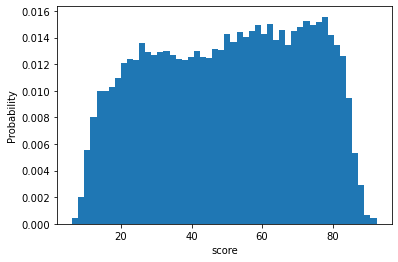

In [105]:
plt.hist(data['score'].values, density=True, bins=50)
plt.ylabel('Probability')
plt.xlabel('score');

In [106]:
image_size = (112, 112)
batch_size = 8
device = 'cuda'

criterion  = nn.MSELoss()
metric = nn.L1Loss()

transform = A.Compose([
    A.Resize(*image_size),
    ToTensorV2()])

dataset = FaceQualityDataset(data, device, transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

## Тестирование pytorch (cuda)

In [107]:
criterion  = nn.MSELoss()
metric = nn.L1Loss()

# Важно в eval переключить, иначе ошибка на валидации возрастет
model = MobileFaceQualityNet().eval().to(device)
model_wrapper = ModelWrapper(model=model)
model_wrapper.load(path_to_model = '../models/pytorch/face_quality_cr-fiqa_metro_mae_3,6_ep_3.pth')

In [108]:
result = model_wrapper.valid(criterion, metric, data_loader)
print(f'Loss: {result["valid_loss"]:.4}', end='\n')
print(f'Metric: {result["valid_metric"]:.4}', end='\n')

Loss: 15.26
Metric: 2.983


In [109]:
def get_pred_pytorch(model: object, dataloader: object) -> np.ndarray:
    model.eval()
    result = np.array([])
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader): 
            inputs = data[0]
            pred_scores = model(inputs)
            pred_scores = pred_scores.view(1, -1)[0]      # [16, 1] -> [16]
            pred_scores_np = pred_scores.detach().cpu().numpy()
            result = np.hstack([result, pred_scores_np])
    return result

In [110]:
valid_y = get_pred_pytorch(model, data_loader)

In [111]:
data['dist_cr_fiq'] = valid_y

## Тестирование ONNX (CPU)

In [58]:
onnxmodel_path = '../models/onnx/cr_fiqa_static_batch_8x3x112x112.onnx'
onnx_model = onnx.load(onnxmodel_path)
onnx.checker.check_model(onnx_model)
ort_session = onnxruntime.InferenceSession(onnxmodel_path, providers=['CPUExecutionProvider'])

In [59]:
def get_pred_onnx(ort_session: object, dataloader: object) -> np.ndarray:
    result = np.array([])
    for batch_idx, data in enumerate(dataloader): 
        inputs = data[0]
        ort_outs = ort_session.run(None, {ort_session.get_inputs()[0].name: to_numpy(inputs)})
        ort_outs = ort_outs[0].reshape(ort_outs[0].shape[0],)
        result = np.hstack([result, ort_outs])
    return result

In [60]:
valid_y_onnx = get_pred_onnx(ort_session, data_loader)

In [61]:
data['onnx_cpu'] = valid_y_onnx

## Тестирование TENSORRT 16

In [98]:
path_to_model = '../models/trt/model_static_max_batch_8_112_fp16.trt'
trt_infer = TrtInfer(path_to_model=path_to_model)

[06/27/2022-17:54:33] [TRT] [W] TensorRT was linked against cuBLAS/cuBLAS LT 11.8.0 but loaded cuBLAS/cuBLAS LT 11.2.1
[06/27/2022-17:54:33] [TRT] [W] TensorRT was linked against cuBLAS/cuBLAS LT 11.8.0 but loaded cuBLAS/cuBLAS LT 11.2.1


In [65]:
def get_pred_tensorrt(trt_infer: object, dataloader: object) -> np.ndarray:
    result = np.array([])
    for batch_idx, data in enumerate(dataloader): 
        inputs = data[0]
        trt_output = trt_infer.inference(to_numpy(inputs))
        result = np.hstack([result, trt_output[0]])
    return result

In [66]:
y_trt_16 = get_pred_tensorrt(trt_infer, data_loader)

In [69]:
data['trt_16'] = y_trt_16

## Тестирование TENSORRT 32

In [74]:
path_to_model = '../models/trt/model_static_max_batch_8_112_fp32.trt'
trt_infer = TrtInfer(path_to_model=path_to_model)

[06/27/2022-17:46:57] [TRT] [W] TensorRT was linked against cuBLAS/cuBLAS LT 11.8.0 but loaded cuBLAS/cuBLAS LT 11.2.1
[06/27/2022-17:46:57] [TRT] [W] TensorRT was linked against cuBLAS/cuBLAS LT 11.8.0 but loaded cuBLAS/cuBLAS LT 11.2.1


In [75]:
y_trt_32 = get_pred_tensorrt(trt_infer, data_loader)

In [76]:
data['trt_32'] = y_trt_32

## Сравнение

In [77]:
data

,path,score,dist_cr_fiq,onnx_cpu,trt_16,trt_32
0,/home/dima/datasets/metro_dataset/1/336080.png,69.005943,71.733521,71.734154,71.875000,71.733887
1,/home/dima/datasets/metro_dataset/1/494830.png,77.437118,78.443466,78.443504,78.375000,78.444138
2,/home/dima/datasets/metro_dataset/1/398431.png,59.581174,54.542908,54.541039,54.531250,54.541477
3,/home/dima/datasets/metro_dataset/1/442370.png,41.054667,40.565643,40.567150,40.500000,40.565491
4,/home/dima/datasets/metro_dataset/1/124570.png,83.540477,80.295120,80.297531,80.250000,80.294365
...,...,...,...,...,...,...
41867,/home/dima/datasets/metro_dataset/0/407140.png,24.396170,27.609613,27.612160,27.390625,27.613712
41868,/home/dima/datasets/metro_dataset/0/83480.png,24.156331,35.607269,35.613720,35.312500,35.614758
41869,/home/dima/datasets/metro_dataset/0/373920.png,9.452589,14.309173,14.307244,14.320312,14.307057
41870,/home/dima/datasets/metro_dataset/0/522570.png,44.500259,36.960449,36.963650,37.000000,36.964310


### GT vs pytorch_cuda

In [78]:
mse = criterion(torch.tensor(data['score'].values), torch.tensor(data['dist_cr_fiq'].values))
mse.item()

15.256822535186602

In [79]:
mae = metric(torch.tensor(data['score'].values), torch.tensor(data['dist_cr_fiq'].values))
mae.item()

2.9828983362735864

### GT vs onnx_cpu

In [80]:
mse = criterion(torch.tensor(data['score'].values), torch.tensor(data['onnx_cpu'].values))
mse.item()

15.256730431011688

In [81]:
mae = metric(torch.tensor(data['score'].values), torch.tensor(data['onnx_cpu'].values))
mae.item()

2.9828766223476695

### GT vs pytorch_trt_16

In [82]:
mse = criterion(torch.tensor(data['score'].values), torch.tensor(data['trt_16'].values))
mse.item()

15.285615915977182

In [83]:
mae = metric(torch.tensor(data['score'].values), torch.tensor(data['trt_16'].values))
mae.item()

2.9858661173607968

### GT vs pytorch_trt_32

In [84]:
mse = criterion(torch.tensor(data['score'].values), torch.tensor(data['trt_32'].values))
mse.item()

15.256807634173805

In [85]:
mae = metric(torch.tensor(data['score'].values), torch.tensor(data['trt_32'].values))
mae.item()

2.9828886746027137